## Complex Precoding LMMSE Pytorch Paper

In [1]:
import math
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy as sp
from scipy.stats import gmean
from scipy.io import loadmat

from time import time
from glob import glob
from bisect import bisect
from functools import partial
from collections import defaultdict
from tqdm import trange

import seaborn as sns
sns.set(rc={'figure.figsize':(9.7,6.27)}, style="whitegrid", font_scale=1.2)

In [2]:
# H (n_users, n_layers, n_antennas)
# W (n_antennas, n_users, n_ranks)

In [3]:
def lin2db(x):
    """ Map linear scale to the logarithmic db """
    return 10 * np.log10(x)

def db2lin(x):
    """ Map linear scale to the logarithmic db """
    return 10 ** (x / 10)
    
def zero_forcing(V):
    """ Zero Forcing precoding in its native implementation """
    return V.solve(V @ V.conj().t())[0].conj().t()

def regularized_singular(V, S, n):
    """ Regularization with inversed squared singular values """
    return V.solve(V @ V.conj().t() + V.shape[0] * ((n / S) ** 2).diag())[0].conj().t()

def regularized(V, n):
    """ Regularization with inversed squared singular values """
    return V.solve(V @ V.conj().t() + V.shape[0] * torch.eye(V.shape[0]) * n ** 2)[0].conj().t()

def wiener(V, n):
    """ Regularization with inversed squared singular values """
    return V.solve(V @ V.conj().t() + V.shape[0] * torch.eye(V.shape[0]) * n)[0].conj().t()

def regularized_numpy(V, S, n):
    """ Regularization with squared singular values """
    return np.linalg.solve(V @ V.conj().T + V.shape[0] * np.diag(n / S) ** 2, V).conj().T

def generalized_test(V, S, d, n):
    """ Generalization of regularized zero forcing with d-scaling """
    return (V * d).solve((V * d) @ V.conj().t() + V.shape[0] * ((n / S) ** 2).diag())[0].conj().t()

def generalized(V, d, n):
    """ Generalization of regularized zero forcing with d-scaling """
    return (V * d).solve((V * d) @ V.conj().t() + V.shape[0] * torch.eye(V.shape[0]) * n ** 2)[0].conj().t()

def normalize_precoding(W):
    """ Make feasible per antenna power with equalization """
    T = W / W.norm(dim=0)
    return T / T.norm(dim=1).max() / T.shape[0] ** 0.5

def normalize_max_antennas(W):
    """ Make feasible per antenna power with equalization """
    return W / W.norm(dim=1).max() / W.shape[0] ** 0.5

def equalize_users_antennas(W):
    T = W / W.norm(dim=0)
    return T / T.norm(dim=1, keepdim=True) / T.shape[0] ** 0.5

def equalize_antennas(W):
    return W / W.norm(dim=1, keepdim=True) / W.shape[0] ** 0.5

def equalize_users_antennas_numpy(W):
    T = W / np.linalg.norm(W, axis=0)
    return T / np.linalg.norm(T, axis=1, keepdims=True) / T.shape[0] ** 0.5

def equalize_antennas_outside(W):
    n = W.norm(dim=1, keepdim=True) * W.shape[0] ** 0.5
    return torch.where(n > 1, W / n, W)

def tgmean(input_x, dim):
    """ Differentiable Torch Geometric Mean """
    log_x = torch.log(input_x)
    return torch.exp(torch.mean(log_x, dim=dim))

def su_sinr(S, s):
    return lin2db(gmean(S.reshape(-1, n_ranks) ** 2, axis=1) / (n_ranks * s ** 2)).mean()

def spectral_efficiency(H, W, s):
    """ Score function is applied for torch complex tensors """
    B = H @ W.reshape(-1, n_users, n_ranks).permute(1, 0, 2)
    K = B.permute(0, 2, 1).conj() @ B + torch.eye(B.shape[2]) * s ** 2
    
    G = B.permute(0, 2, 1).conj().solve(K)[0]
    G = torch.block_diag(*G)
    
    A = (G @ H.reshape(-1, n_antennas) @ W).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(dim=1) * s ** 2
    D = N - A.diag()
    L = tgmean(((N / D) - 1).reshape(-1, n_ranks), dim=-1)
    return (1 + L).log2().mean() * n_ranks

def min_spectral_efficiency(H, W, s):
    """ Score function is applied for torch complex tensors """
    B = H @ W.reshape(-1, n_users, n_ranks).permute(1, 0, 2)
    K = B.permute(0, 2, 1).conj() @ B + torch.eye(B.shape[2]) * s ** 2
    
    G = B.permute(0, 2, 1).conj().solve(K)[0]
    G = torch.block_diag(*G)
    
    A = (G @ H.reshape(-1, n_antennas) @ W).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(dim=1) * s ** 2
    D = N - A.diag()
    L = tgmean(((N / D) - 1).reshape(-1, n_ranks), dim=-1)
    return (1 + L).log2().min() * n_ranks

def spectral_efficiency_irc(H, W, s):
    """ Score function is applied for torch complex tensors """
    X = H.reshape(-1, n_antennas) @ W
    Y = X.reshape(n_users, n_layers, n_users, n_ranks)
    Z = Y.permute(0, 2, 1, 3) @ Y.permute(0, 2, 3, 1).conj()
    J = Z.permute(0, 2, 1, 3).reshape([n_users * n_layers] * 2)

    R = J.reshape(n_users, n_layers, n_users, n_layers).sum(dim=2)
    Q = torch.eye(R.shape[1]) * s ** 2

    B = H @ W.reshape(-1, n_users, n_ranks).permute(1, 0, 2)
    G = B.solve(R + Q)[0].permute(0, 2, 1).conj()
    G = torch.block_diag(*G)

    A = (G @ X).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(axis=1) * s ** 2
    D = N - A.diag()
    L = tgmean(((N / D) - 1).reshape(-1, n_ranks), dim=-1)
    return (1 + L).log2().mean() * n_ranks

def min_spectral_efficiency_irc(H, W, s):
    """ Score function is applied for torch complex tensors """
    X = H.reshape(-1, n_antennas) @ W
    Y = X.reshape(n_users, n_layers, n_users, n_ranks)
    Z = Y.permute(0, 2, 1, 3) @ Y.permute(0, 2, 3, 1).conj()
    J = Z.permute(0, 2, 1, 3).reshape([n_users * n_layers] * 2)

    R = J.reshape(n_users, n_layers, n_users, n_layers).sum(dim=2)
    Q = torch.eye(R.shape[1]) * s ** 2

    B = H @ W.reshape(-1, n_users, n_ranks).permute(1, 0, 2)
    G = B.solve(R + Q)[0].permute(0, 2, 1).conj()
    G = torch.block_diag(*G)

    A = (G @ X).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(axis=1) * s ** 2
    D = N - A.diag()
    L = tgmean(((N / D) - 1).reshape(-1, n_ranks), dim=-1)
    return (1 + L).log2().min() * n_ranks

def shannon_efficience(V, W, S, s):
    """ Score function is applied for torch complex tensors
            sum_k (log (sum_l |<f_k, w_l>|^2 + s^2) - 
                        log (sum_{l\k} |<f_k, w_l>|^2 + s^2)) 
    """
    A = (V @ W).abs() ** 2
    N = A.sum(dim=1) + (s / S) ** 2 * V.shape[0]
    D = N - A.diag()
    L = N.log2() - D.log2()
    return L.mean()
    #L = tgmean(((N / D) - 1).reshape(-1, n_ranks), dim=-1)
    #return (1 + L).log().mean() * n_ranks
    
def compute_beta(V, W, s):
    A = V @ W
    N = A.diag()
    D1 = (A.abs() ** 2).sum(dim=0) 
    D2 = (W.abs() ** 2).sum(dim=0) * s ** 2
    return (N / (D1 + D2)).conj()

def compute_alpha(V, W, s):
    A = W @ V
    N = A.diag()
    D1 = (A.abs() ** 2).sum(dim=1) 
    D2 = (W.abs() ** 2).sum(dim=1) * s ** 2
    return (N / (D1 + D2)).conj()
    
def quantize(X):
    return (X / X.abs().max() * 128).round()
    
def quantized_zero_forcing(V):
    W = regularized(V, s)
    return torch.complex(
        quantize(W.real), quantize(W.imag))

def beta_quantized_zero_forcing(V, s):
    W = quantized_zero_forcing(V)
    return compute_beta(V, W, s) * W

def alpha_quantized_zero_forcing(V, s):
    W = quantized_zero_forcing(V)
    return compute_alpha(V, W, s)[:, None] * W

def generate_channel(n_users, n_layers, n_antennas):
    """ Sample channel matrix H from the complex normal distribution CN(0, I) """
    return np.random.randn(n_users, n_layers, n_antennas, 2).view(complex).squeeze() / 2 ** 0.5

$W = K V^H ( V V^H + \sigma I)^{-1} L \rightarrow \max_{\sigma \in R}$

### SVD-Decomposition

Each user channel $H$ has $m$ layers and $n$ bs-antennas:

$ H = U^* \Sigma V \quad H, V \in \mathbb{R}^{m \times n} \quad U^*, \Sigma \in \mathbb{R}^{m \times m}$

$ H U = \Sigma V$

$r = G(HWx + n) = GHWx +Gn$

$ A = GHW, A^{N \times N} $

### Partial SVD: 

$H \sim U^H S V, V^{L \times M}, H^{N \times M}, L \leq N$

$M = 64, N = 4, L = 2$

$ G = S^{-1} U $

$r = S^{-1} U ( U^H S V Wx + n)$

$r = VW x + S^{-1} U n$

$A = VW, A^{L \times L}$

$r = HWx + n, \|x\| \le 1, trace ( xx^* ) = 1$

### LMMSE Proof

$\|r - x\|^2 = \|HWx - x \|^2 = \| (HW - I) x \|^2 \leq \| HW - I\|^2 -> \min_W : W = H^\dagger$

$ <HWx, HWx> - 2<HWx, x> + <x, x> = <(HW)^* HW , x x^*> - 2 <HW, x x^*>$

$W = (H^*H)^{-1}H^*$

$W = H^* (H H^*)^{-1}$

### Massive Experiments

In [4]:
from collections.abc import Sequence

class FlyingSuSinr(Sequence):
    def __init__(self, S, s_grid):
        """Construct a lazy sequence representation"""
        self.s_grid = s_grid
        self.n = len(self.s_grid)
        self.sinr = partial(su_sinr, S)
    def __len__(self):
        return self.n
    def __getitem__(self, i):
        if not (0 <= i < self.n):
            raise IndexError
        return self.sinr(self.s_grid[i])

In [5]:
from torch.optim import LBFGS

def diagonal_regularizer_solver(H, V, S, s):
    x = (s / S).requires_grad_()
    optim = LBFGS([x], line_search_fn="strong_wolfe")
    def closure():
        W = normalize_max_antennas(regularized(V, x))
        func = -spectral_efficiency(H, W, s)
        optim.zero_grad()
        func.backward()
        return func
    optim.step(closure)
    return x.detach()

def calc_corr(C):
    return ((np.abs(C @ C.conj().T) - np.eye(C.shape[0])) ** 2).mean()

# Sanity check before massive experiments

In [6]:
ls "Channels/n_users=4/3GPP_38.901_UMa_NLOS/far_users/urban/notcorrelated_users/"

coeff.1.mat   coeff.26.mat  coeff.36.mat  coeff.3.mat   coeff.7.mat
coeff.24.mat  coeff.2.mat   coeff.38.mat  coeff.40.mat  coeff.9.mat


In [7]:
path = "Channels/n_users=4/3GPP_38.901_UMa_NLOS/far_users/urban/notcorrelated_users/coeff.24.mat"

In [8]:
H = loadmat(path)["coeff"][..., -1]
H[0] *= 10
H[1] *= 2
H[2] /= 2
H[3] /= 10

n_users, n_layers, n_antennas = H.shape # Global constants
S, V = np.linalg.svd(H, full_matrices=False)[1:]
S_max = S[:, 0].max()
H /= S_max; S /= S_max

target_sinr = 20
s_grid = np.logspace(1, -5, num=200)
n_antennas, n_ranks = 64, 2

In [9]:
flying_sinr = FlyingSuSinr(S, s_grid)
s = s_grid[bisect(flying_sinr, target_sinr)]
s

0.0014820207057988585

In [10]:
V = torch.from_numpy(V[:, :n_ranks, :].reshape(-1, n_antennas))
S = torch.from_numpy(S[:, :n_ranks].flatten())
H = torch.from_numpy(H)

In [11]:
W = normalize_precoding(regularized_singular(V, S, s))
spectral_efficiency_irc(H, W, s)

<ipython-input-3-4baae0ea1346>:15: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811740025/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return V.solve(V @ V.conj().t() + V.shape[0] * ((n / S) ** 2).diag())[0].conj().t()


tensor(11.0170, dtype=torch.float64)

In [12]:
W = normalize_precoding(zero_forcing(V))
spectral_efficiency_irc(H, W, s)

tensor(10.3239, dtype=torch.float64)

In [13]:
W = normalize_precoding(regularized(V, s))
spectral_efficiency_irc(H, W, s)

tensor(10.3241, dtype=torch.float64)

In [14]:
history, times = defaultdict(list), defaultdict(list)
s_grid = np.logspace(1, -10, num=200)
n_antennas, n_ranks = 64, 2
#full_path = "Channels/n_users=4/3GPP_38.901_UMa_NLOS/far_users/urban/notcorrelated_users/*"
full_path = "Channels/n_users=4/3GPP_38.901_UMa_NLOS/**/*.mat"

for target_sinr in trange(0, 41, 4):
    for i, path in enumerate(glob(full_path, recursive=True)):
        H = loadmat(path)["coeff"][..., -1]
        H[0] *= 10
        H[1] *= 2
        H[2] /= 2
        H[3] /= 10
        n_users, n_layers, n_antennas = H.shape # Global constants
        S, V = np.linalg.svd(H, full_matrices=False)[1:]
        S_max = S[:, 0].max()
        H /= S_max; S /= S_max

        flying_sinr = FlyingSuSinr(S, s_grid)
        s = s_grid[bisect(flying_sinr, target_sinr)]
        
        history["Correlation"].append(calc_corr(V[:, 0, :]))
        
        V = torch.from_numpy(V[:, :n_ranks, :].reshape(-1, n_antennas))
        S = torch.from_numpy(S[:, :n_ranks].flatten())
        H = torch.from_numpy(H)
        
        start = time()
        W_MR = normalize_max_antennas(V.conj().t())
        times["Maximum-Ratio"].append(time() - start)
        
        start = time()
        W_NMR = normalize_max_antennas(S * V.conj().t())
        times["Maximum-Ratio"].append(time() - start)
        
        start = time()
        W_ZF = normalize_max_antennas(zero_forcing(V))
        times["Zero-Forcing"].append(time() - start)
        
        start = time()
        W_NZF = normalize_max_antennas(zero_forcing(S.unsqueeze(1) * V))
        times["Un-normalized Zero-Forcing"].append(time() - start)
        
        start = time()
        W_RG = normalize_max_antennas(regularized(V, s))
        times["Regularized Zero-Forcing"].append(time() - start)
        
        start = time()
        W_WRG = normalize_max_antennas(wiener(V, ((s / S) ** 2).mean()))
        times["Wiener Zero-Forcing"].append(time() - start)
        
        start = time()
        W_SRG = normalize_max_antennas(regularized_singular(V, S, s))
        times["Singular Value Based Zero-Forcing"].append(time() - start)
        
        start = time()
        W_NSRG = normalize_max_antennas(regularized(S.unsqueeze(1) * V, s))
        times["Unnormalized Regularized Zero-Forcing"].append(time() - start)

        start = time()
        r = diagonal_regularizer_solver(H, V, S, s)
        W_DR = normalize_max_antennas(regularized(V, r))
        times["Optimal RZF"].append(time() - start)
        
        history["$W_{MRT}(V)$"].append(float(spectral_efficiency(H, W_MR, s)))
        history["$W_{ZF}(V)$"].append(float(spectral_efficiency(H, W_ZF, s)))
        history["$W_{ZF}(F)$"].append(float(spectral_efficiency(H, W_NZF, s)))
        history["$W_{RZF}(V)$"].append(float(spectral_efficiency(H, W_RG, s)))
        history["$W_{RZF}(F)$"].append(float(spectral_efficiency(H, W_NSRG, s)))        
        history["$W_{WRZF}(V)$"].append(float(spectral_efficiency(H, W_WRG, s)))
        history["$W_{ARZF}(V)$"].append(float(spectral_efficiency(H, W_SRG, s)))
        history["$W_{OPT}(V)$"].append(float(spectral_efficiency(H, W_DR, s)))
        history["SU SINR"].append(target_sinr)

100%|██████████| 11/11 [00:45<00:00,  4.16s/it]


In [15]:
F = S.unsqueeze(1) * V
W1 = normalize_precoding(regularized(F, s))

In [16]:
W2 = normalize_precoding(regularized_singular(V, S, s))

In [17]:
spectral_efficiency(H, W1, s)

tensor(13.1487, dtype=torch.float64)

In [18]:
spectral_efficiency(H, W2, s)

tensor(13.1487, dtype=torch.float64)

In [19]:
np.mean(history['Correlation']).round(3)

0.076

In [20]:
np.std(history['Correlation']).round(3)

0.051

In [21]:
history = pd.DataFrame(history)
#history["SU SINR"] /= 2
history.drop(columns="Correlation", inplace=True)
history_mean = history.groupby("SU SINR").mean()
history_std = history.groupby("SU SINR").std()

scenario_name = '_'.join(full_path.split('/')[1:-1])
scenario_name = scenario_name.replace("=", "_")
scenario_name

'n_users_4_3GPP_38.901_UMa_NLOS_**'

In [22]:
history_mean

,$W_{MRT}(V)$,$W_{ZF}(V)$,$W_{ZF}(F)$,$W_{RZF}(V)$,$W_{RZF}(F)$,$W_{WRZF}(V)$,$W_{ARZF}(V)$,$W_{OPT}(V)$
SU SINR,,,,,,,,
0,1.451542,2.267965,0.020171,2.365226,2.464740,1.483459,3.912436,4.067071
4,1.753262,3.128448,0.048088,3.187040,2.793446,1.843604,4.910396,5.096638
8,2.082739,4.162559,0.113224,4.194968,3.095061,2.328960,6.030672,6.320844
12,2.405958,5.292462,0.260405,5.310206,3.374939,3.018081,7.170717,7.629245
16,2.712676,6.513081,0.542037,6.522406,3.610931,4.017426,8.228639,9.010113
20,2.994832,7.787475,1.026785,7.792343,3.660266,5.475095,9.260370,10.423454
24,3.243548,9.050578,1.746925,9.053121,3.761787,7.293116,10.230525,11.743740
28,3.474316,10.399902,2.772358,10.401131,4.083118,9.581010,11.239982,13.094654
32,3.645106,11.653975,3.949173,11.654567,4.726035,11.599106,12.186724,14.172361


history_mean.to_excel("Tables/Opt_Avg_SE_4_Users_Urban_NLOS_Paper_Native.xlsx")

In [23]:
100 * (history_mean['$W_{ARZF}(V)$'] / history_mean["$W_{RZF}(V)$"] - 1)

SU SINR
0     65.414923
4     54.073865
8     43.759676
12    35.036524
16    26.159560
20    18.839361
24    13.005500
28     8.064994
32     4.566083
36     2.337137
40     1.079581
dtype: float64

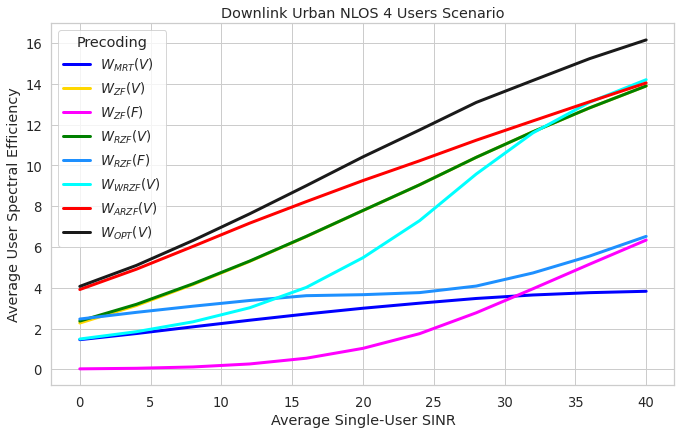

In [24]:
history_mean.columns.name = "Precoding"
history_mean.index.name = "Average Single-User SINR"
ax = history_mean.plot(lw=3,# yerr=history_std, alpha=0.9, 
                    color=['blue', 'gold', 'magenta', 'green', 'dodgerblue', 'cyan', 'red', 'k'])
ax.set_ylabel("Average User Spectral Efficiency")
plt.title("Downlink Urban NLOS 4 Users Scenario")

# for n in history_mean:
#     ax.fill_between(history_mean[n].index, history_mean[n] - history_std[n],
#                     history_mean[n] + history_std[n], alpha=0.1)

plt.tight_layout()
plt.savefig("Avg_SE_4_Users_Urban_NLOS_Paper_Pathloss.pdf")

In [25]:
print(history_mean.round(2).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
Precoding &  \$W\_\{MRT\}(V)\$ &  \$W\_\{ZF\}(V)\$ &  \$W\_\{ZF\}(F)\$ &  \$W\_\{RZF\}(V)\$ &  \$W\_\{RZF\}(F)\$ &  \$W\_\{WRZF\}(V)\$ &  \$W\_\{ARZF\}(V)\$ &  \$W\_\{OPT\}(V)\$ \\
Average Single-User SINR &               &              &              &               &               &                &                &               \\
\midrule
0                        &          1.45 &         2.27 &         0.02 &          2.37 &          2.46 &           1.48 &           3.91 &          4.07 \\
4                        &          1.75 &         3.13 &         0.05 &          3.19 &          2.79 &           1.84 &           4.91 &          5.10 \\
8                        &          2.08 &         4.16 &         0.11 &          4.19 &          3.10 &           2.33 &           6.03 &          6.32 \\
12                       &          2.41 &         5.29 &         0.26 &          5.31 &          3.37 &           3.02 &           7.17 &          7.

### SU-SINR Defines Everything

In [26]:
H = loadmat(path)["coeff"][..., -1]
n_users, n_layers, n_antennas = H.shape # Global constants
S, V = np.linalg.svd(H, full_matrices=False)[1:]
S_max = S[:, 0].max()

V = torch.from_numpy(V[:, :n_ranks, :].reshape(-1, n_antennas))
S = torch.from_numpy(S[:, :n_ranks].flatten())
H = torch.from_numpy(H)

flying_sinr = FlyingSuSinr(S, s_grid)
s = s_grid[bisect(flying_sinr, target_sinr)]

H /= S_max; S /= S_max


s /= S_max
s

0.0040616087798206815

In [27]:
su_sinr(S, s)

40.21984390430612

In [28]:
W_RG = normalize_precoding(regularized(V, s))
spectral_efficiency(H, W_RG, s)

tensor(14.8007, dtype=torch.float64)

In [29]:
r = diagonal_regularizer_solver(H, V, S, s)
W_DR = normalize_max_antennas(regularized(V, r))
spectral_efficiency(H, W_DR, s)

tensor(15.9189, dtype=torch.float64)

In [30]:
H = loadmat(path)["coeff"][..., -1]
n_users, n_layers, n_antennas = H.shape # Global constants
S, V = np.linalg.svd(H, full_matrices=False)[1:]
#S_max = S[:, 0].max()
#H /= S_max; S /= S_max

V = torch.from_numpy(V[:, :n_ranks, :].reshape(-1, n_antennas))
S = torch.from_numpy(S[:, :n_ranks].flatten())
H = torch.from_numpy(H)

s *= S_max
s

0.11623224686798525

In [31]:
su_sinr(S, s)

40.21984390430612

In [32]:
spectral_efficiency(H, W_RG, s)

tensor(14.8007, dtype=torch.float64)

In [33]:
spectral_efficiency(H, W_DR, s)

tensor(15.9189, dtype=torch.float64)

### Noise Reweigthing

In [34]:
H = loadmat(path)["coeff"][..., -1]
n_users, n_layers, n_antennas = H.shape # Global constants
S, V = np.linalg.svd(H, full_matrices=False)[1:]
S_max = S[:, 0].max()
#H /= S_max; S /= S_max

V = torch.from_numpy(V[:, :n_ranks, :].reshape(-1, n_antennas))
S = torch.from_numpy(S[:, :n_ranks].flatten())
H = torch.from_numpy(H)

flying_sinr = FlyingSuSinr(S, s_grid)
s = s_grid[bisect(flying_sinr, target_sinr)]

s

0.11623224686798524

In [35]:
su_sinr(S, s)

40.21984390430612

In [36]:
W_RG = normalize_precoding(regularized(V, s))
spectral_efficiency(H, W_RG, s)

tensor(13.1401, dtype=torch.float64)

In [37]:
r = diagonal_regularizer_solver(H, V, S, s)
W_DR = normalize_max_antennas(regularized(V, r))
spectral_efficiency(H, W_DR, s)

tensor(15.9189, dtype=torch.float64)

In [38]:
H /= S_max; S /= S_max

In [39]:
spectral_efficiency(H, W_RG, s)

tensor(2.0223, dtype=torch.float64)

In [40]:
spectral_efficiency(H, W_DR, s)

tensor(1.9605, dtype=torch.float64)

In [41]:
spectral_efficiency(H, W_RG, s / S_max)

tensor(13.1401, dtype=torch.float64)

In [42]:
spectral_efficiency(H, W_DR, s / S_max)

tensor(15.9189, dtype=torch.float64)